# Clustering

Group stocks into 4 risk profiles using K-Means.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import sys
sys.path.append('../src')

from clustering import *

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

## Load Features

In [2]:
df = pd.read_csv('../Data/Processed/nse_features.csv')
print(f"Loaded {len(df)} stocks")
df.head()

Loaded 57 stocks


,Stock_code,Sector,Name,volatility_mean,volatility_max,volatility_5d,downside_deviation,var_95,max_drawdown,mean_return,...,bb_width_mean,macd_volatility,avg_volume,volume_volatility,amihud_illiquidity,trading_frequency,momentum_20d,momentum_60d,trend_strength,current_price
0,ABSA,Banking,ABSA Bank Kenya Plc,0.012240,0.032507,0.010669,0.007478,-0.017853,-0.236220,0.000743,...,2.296415,0.176010,457918.016194,1.206789e+06,3.464928e-09,1.000000,0.168285,0.284698,0.183930,18.05
1,BAMB,Construction and Allied,Bamburi Cement Ltd,0.023726,0.089329,0.021072,0.013241,-0.030420,-0.514563,0.000901,...,3.867892,1.282150,233655.667351,4.414206e+06,1.904103e-08,0.985830,-0.140625,-0.063830,-0.088486,55.00
2,BAT,Manufacturing and Allied,British American Tobacco Kenya Plc,0.011709,0.027272,0.010182,0.006908,-0.015898,-0.348232,0.000126,...,1.752410,5.776191,19173.611111,5.648945e+04,1.622817e-09,0.947368,0.075823,0.094614,0.068561,376.00
3,BKG,Banking,BK Group Plc,0.028116,0.057793,0.024537,0.016608,-0.041967,-0.392500,0.001923,...,3.561992,0.576050,86221.114865,5.454811e+05,0.000000e+00,0.599190,-0.038405,-0.028358,-0.031970,32.55
4,BOC,Manufacturing and Allied,BOC Kenya Plc,0.025316,0.054629,0.019874,0.015212,-0.034998,-0.302949,0.001758,...,3.670978,1.450247,10246.268657,7.566827e+04,0.000000e+00,0.406883,-0.002809,0.123418,0.055134,88.75


## Find Optimal K

In [3]:
# Features for clustering
feature_cols = [
    'volatility_mean', 'volatility_max', 'downside_deviation',
    'std_return', 'var_95', 'max_drawdown',
    'sharpe_ratio', 'return_skew', 'return_kurtosis',
    'rsi_mean', 'bb_width_mean', 'macd_volatility',
    'momentum_20d', 'momentum_60d', 'trend_strength',
    'trading_frequency', 'amihud_illiquidity', 'volume_volatility'
]

# Only use features that exist
feature_cols = [col for col in feature_cols if col in df.columns]
print(f"\nUsing {len(feature_cols)} features")

cluster_metrics = find_optimal_clusters(df, feature_cols, max_clusters=8)
print(cluster_metrics)


Using 18 features
   n_clusters      inertia  silhouette
0           2  6947.292351    0.646001
1           3  5520.129770    0.610329
2           4  4439.593829    0.620937
3           5  3504.889284    0.521133
4           6  2925.652278    0.535139
5           7  2132.788255    0.550571
6           8  1472.617954    0.473843


In [4]:
len(feature_cols)

18

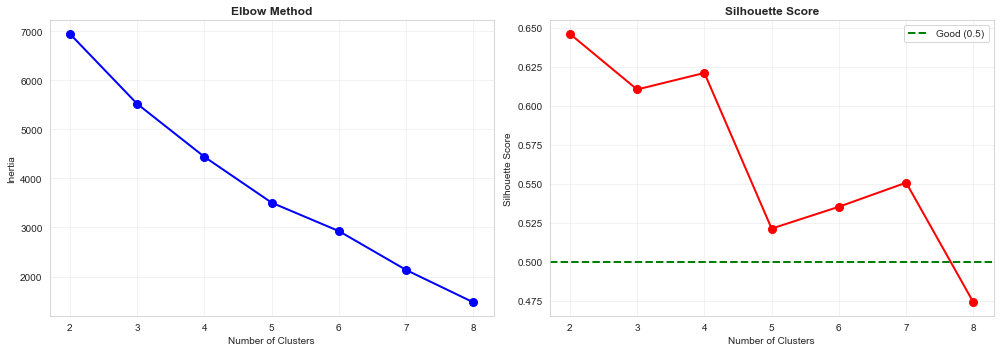


Best K = 2 (highest silhouette)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax1.plot(cluster_metrics['n_clusters'], cluster_metrics['inertia'], 'bo-', linewidth=2, markersize=8)
ax1.set_title('Elbow Method', fontweight='bold')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.grid(True, alpha=0.3)

# Silhouette plot
ax2.plot(cluster_metrics['n_clusters'], cluster_metrics['silhouette'], 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.5, color='g', linestyle='--', label='Good (0.5)', linewidth=2)
ax2.set_title('Silhouette Score', fontweight='bold')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k = cluster_metrics.loc[cluster_metrics['silhouette'].idxmax(), 'n_clusters']
print(f"\nBest K = {int(best_k)} (highest silhouette)")

## Train Model

In [6]:
clusterer = StockClusterer(n_clusters=4, random_state=42)
df_clustered = clusterer.fit_predict(df)

print(f"\nCluster Distribution:")
print(df_clustered['Risk_Profile'].value_counts())

Using 15 features for clustering:
std_return, volatility_mean, volatility_max, max_drawdown, downside_deviation, var_95, sharpe_ratio, return_skew, return_kurtosis, rsi_mean, bb_width_mean, momentum_20d, momentum_60d, trading_frequency, amihud_illiquidity
Cluster 0: Low Risk (52 stocks)
Cluster 3: Medium-Low Risk (1 stocks)
Cluster 1: Medium-High Risk (3 stocks)
Cluster 2: High Risk (1 stocks)

 Clustering complete!
 Silhouette Score: 0.717
EXCELLENT separation! (≥0.5)

Cluster Distribution:
Low Risk            52
Medium-High Risk     3
High Risk            1
Medium-Low Risk      1
Name: Risk_Profile, dtype: int64


## Visualize with PCA

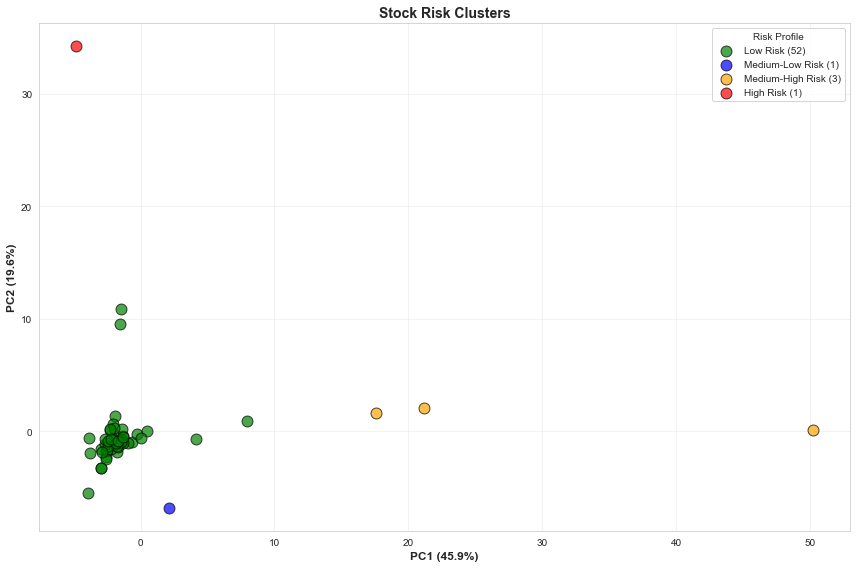

In [7]:
# Prepare data
X = df_clustered[clusterer.feature_columns].fillna(df_clustered[clusterer.feature_columns].median())
X_scaled = clusterer.scaler.transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12, 8))
colors = ['green', 'blue', 'orange', 'red']
labels = ['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']

for i, (color, label) in enumerate(zip(colors, labels)):
    mask = df_clustered['Risk_Profile'] == label
    if mask.sum() > 0:
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=color, label=f"{label} ({mask.sum()})",
                    alpha=0.7, s=120, edgecolors='black', linewidth=1)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12, fontweight='bold')
plt.title('Stock Risk Clusters', fontsize=14, fontweight='bold')
plt.legend(title='Risk Profile', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Cluster Profiles

In [8]:
summary = clusterer.get_cluster_summary(df_clustered)
print("\nCluster Summary:")
print(summary)


Cluster Summary:
                  Count  Avg Volatility  Sharpe Ratio  Avg Drawdown  \
Risk_Profile                                                          
High Risk             1          0.0039        0.8866       -0.0698   
Low Risk             52          0.0268        0.0184       -0.4786   
Medium-High Risk      3          0.0203        0.0140       -0.5520   
Medium-Low Risk       1          0.0217       -0.0102       -0.6376   

                  Trading Freq  Median Volume  
Risk_Profile                                   
High Risk               0.0425     43923.8095  
Low Risk                0.8152     26955.8233  
Medium-High Risk        0.9983    630362.6518  
Medium-Low Risk         1.0000    765106.6802  


## Sample Stocks

In [9]:
for risk in ['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']:
    subset = df_clustered[df_clustered['Risk_Profile'] == risk]
    if len(subset) > 0:
        print(f"\n{'='*60}")
        print(f"{risk} ({len(subset)} stocks)")
        print('='*60)
        
        cols = ['Stock_code', 'Name', 'Sector', 'volatility_mean', 'sharpe_ratio']
        available_cols = [c for c in cols if c in subset.columns]
        
        sample = subset.nsmallest(min(5, len(subset)), 'volatility_mean')[available_cols]
        print(sample.to_string(index=False))


Low Risk (52 stocks)
Stock_code                                Name                    Sector  volatility_mean  sharpe_ratio
       GLD                    ABSA NewGold ETF     Exchange Traded Funds         0.006756      0.210668
      LIMT                      Limuru Tea Plc              Agricultural         0.008081      0.037256
      SCBK   Standard Chartered Bank Kenya Ltd                   Banking         0.010536      0.052328
       BAT  British American Tobacco Kenya Plc  Manufacturing and Allied         0.011709      0.001858
      ABSA                 ABSA Bank Kenya Plc                   Banking         0.012240      0.047122

Medium-Low Risk (1 stocks)
Stock_code                                Name     Sector  volatility_mean  sharpe_ratio
      KNRE  Kenya Re-Insurance Corporation Ltd  Insurance         0.021732     -0.010154

Medium-High Risk (3 stocks)
Stock_code                                      Name                Sector  volatility_mean  sharpe_ratio
      KEGN  K

## Save Results

In [10]:
# Save clustered data
df_clustered.to_csv('../Data/Processed/nse_clustered.csv', index=False)
print("Saved clustered data")

# Save model
clusterer.save_model('../models/stock_clusterer.pkl')

Saved clustered data
Model saved to ../models/stock_clusterer.pkl


## Model Evaluation

### Objective
The aim of the clustering model is to group NSE stocks into **interpretable risk profiles** based on volatility, downside risk, return behaviour, liquidity and momentum characteristics.  
The objective is not to obtain equally sized clusters, but to identify **distinct risk behaviours**.

---

### Features and Preprocessing
The model uses 15 engineered features capturing volatility, downside risk, tail risk, return distribution shape, technical behaviour, momentum and liquidity.  
Missing values are imputed using the median and all features are scaled using **RobustScaler** to reduce the influence of outliers.

---

### Choice of Number of Clusters
The silhouette coefficient was evaluated for values of *k* between 2 and 8.  
Although *k = 2* produced the highest silhouette score, **k = 4** was selected to allow a more informative and graded segmentation of stock risk (low, medium-low, medium-high and high risk).  
The silhouette score for *k = 4* is only marginally lower and provides a better trade-off between clustering quality and interpretability.

---

### Clustering Quality
The final model achieved a silhouette score of **0.717**, indicating excellent separation between clusters in the feature space.

---

### Cluster Distribution

| Risk Profile    | Number of Stocks |
|-----------------|------------------|
| Low Risk        | 52               |
| Medium-Low Risk | 1                |
| Medium-High Risk| 3                |
| High Risk       | 1                |

---

### Interpretation
The highly imbalanced distribution reflects the structure of the dataset, where most stocks exhibit similar and relatively stable risk characteristics.  
The small clusters correspond to stocks with **atypical or extreme risk behaviour** and should be interpreted as outlier risk profiles rather than broad market segments.  
The high silhouette score is partly driven by the strong separation between these extreme stocks and the dominant low-risk group.

---

### Limitations
Some risk profiles contain very few stocks, which limits their usefulness as stand-alone segments.  
In addition, the clustering is mainly driven by volatility and downside-risk features, and therefore does not fully capture sector-specific or fundamental differences.
